In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
register_matplotlib_converters()
from time import time
import pmdarima as pm

# Import meal data

In [4]:
#read data
cgm_to_meal = pd.read_csv('data/cgm_to_meal.csv')
cgm_to_meal = cgm_to_meal.dropna()
cgm_to_meal = cgm_to_meal.loc[cgm_to_meal['meal']==0]
cgm_to_meal.head()

,cgm,meal
0,118.0,0
1,122.0,0
5,124.0,0
6,126.0,0
7,127.0,0


In [5]:
cgm_to_meal = cgm_to_meal['cgm'].to_numpy()

Text(0, 0.5, 'CGM')

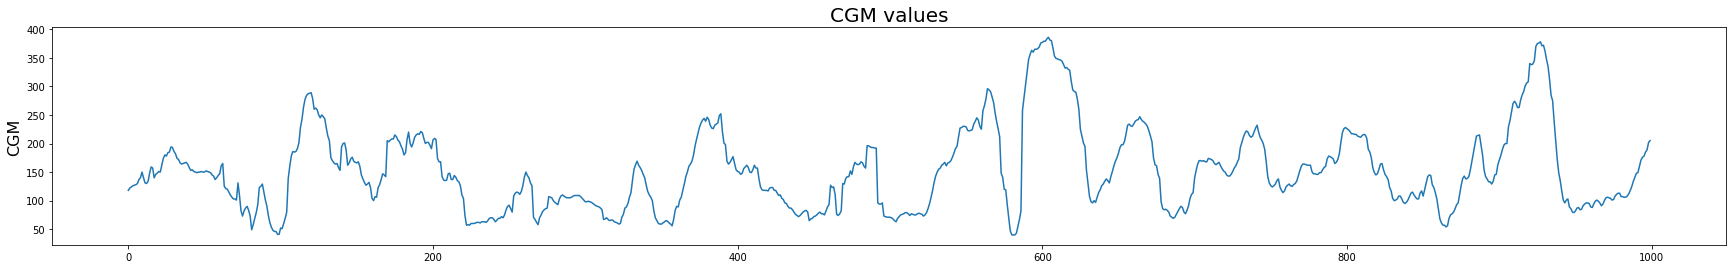

In [6]:
plt.figure(figsize=(30,4))
plt.plot(cgm_to_meal[:1000])
plt.title('CGM values', fontsize=20)
plt.ylabel('CGM', fontsize=16)

# ACF

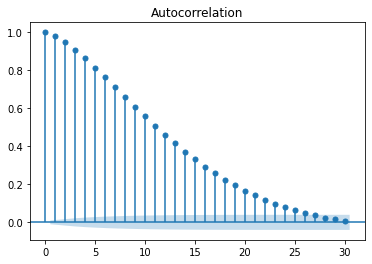

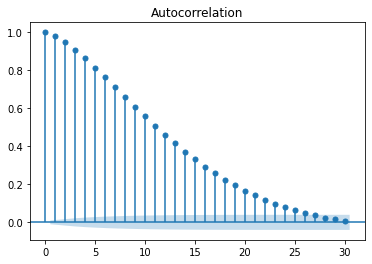

In [92]:
# acf_vals = acf(cgm_to_meal['cgm'])
# num_lags = 1000
# plt.bar(range(num_lags), acf_vals[:num_lags])
plot_acf(cgm_to_meal, lags=30)

# PACF

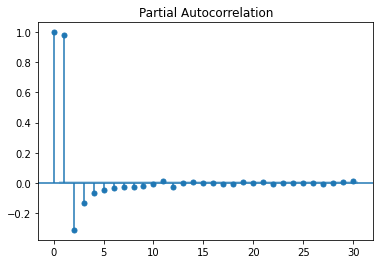

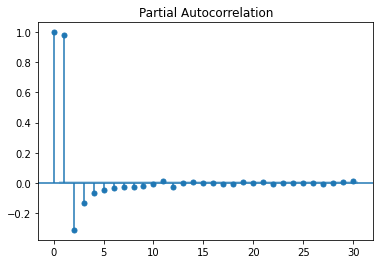

In [93]:
plot_pacf(cgm_to_meal, lags=30)

## Based on PACF, we should start with a seasonal AR process

# Get training and testing sets

# Fit the SARIMA Model

In [55]:
# working setting -->
# train_data = cgm_to_meal[:10000]
# my_order = (5,0,20)
# my_seasonal_order = (1, 0, 1, 30)
# # define model
# # model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
# model = SARIMAX(train_data, order=my_order)

train_data = cgm_to_meal[:10000]
my_order = (5,0,20)
my_seasonal_order = (1, 0, 1, 400)
# define model
# model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
model = SARIMAX(train_data, order=my_order)

In [56]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Model Fitting Time: 71.36634302139282


In [57]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                10000
Model:              SARIMAX(5, 0, 20)   Log Likelihood              -37651.670
Date:                Thu, 26 Nov 2020   AIC                          75355.341
Time:                        14:38:31   BIC                          75542.809
Sample:                             0   HQIC                         75418.798
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8895      0.034    -25.971      0.000      -0.957      -0.822
ar.L2          1.5679      0.029     53.249      0.000       1.510       1.626
ar.L3          1.7510      0.051     34.255      0.0

In [73]:
test_data = cgm_to_meal[10000:10020]
test_data

array([122., 116., 112., 107., 118., 126., 133., 136., 136., 133., 126.,
       121., 124., 124., 131., 148., 155., 160., 159., 163.])

In [74]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
# predictions = model_fit.predict(2000, 2020)
predictions = pd.Series(predictions)
residuals = test_data - predictions

Text(0, 0.5, 'Error')

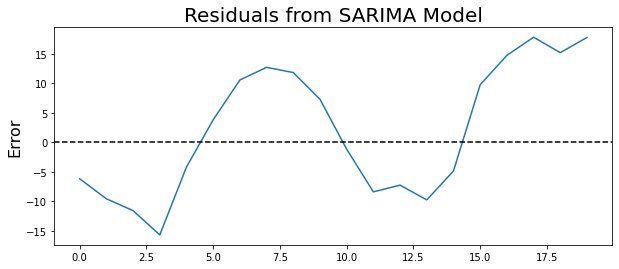

In [75]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

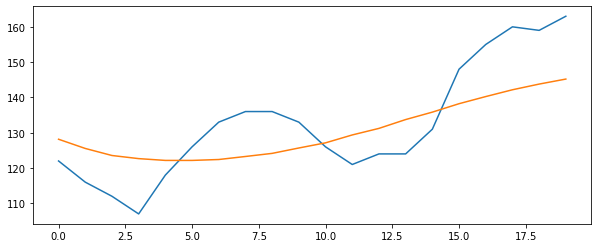

In [76]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)


In [42]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0746


In [43]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 11.020974093968064


# Using the Rolling Forecast Origin

In [22]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_catfish_sales[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [23]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

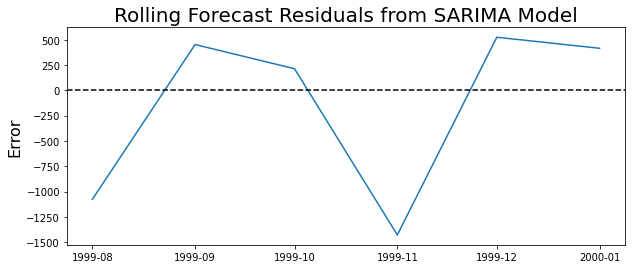

In [24]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

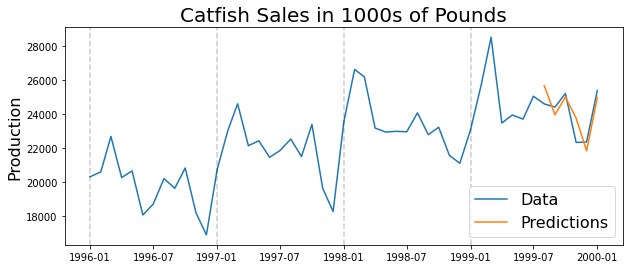

In [25]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [26]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0291


In [27]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 805.7695079859997


In [8]:
model = pm.auto_arima(train_data, seasonal=True)

c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\usoni1\pycharmprojects\mc-final-project\python37_venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. 

In [26]:
model.param_names

['ar.L1', 'ar.L2', 'ar.L3', 'ar.L4', 'ar.L5', 'ma.L1', 'ma.L2', 'sigma2']

In [19]:
test_data = cgm_to_meal[10000:10100]
predictions = model.predict(len(test_data))
predictions = pd.Series(predictions)
residuals = test_data - predictions

Text(0, 0.5, 'Error')

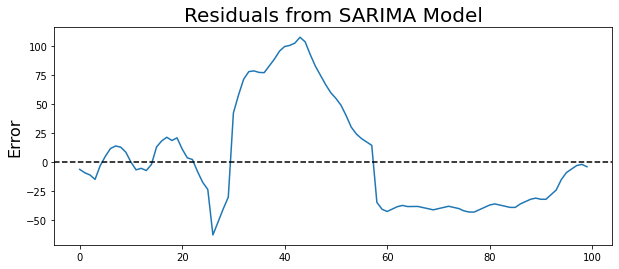

In [20]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

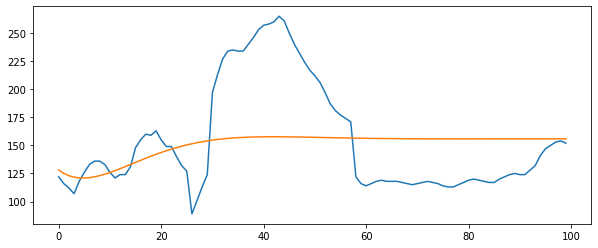

In [21]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)
